In [1]:
#%gui wx
%matplotlib inline

In [2]:
from __future__ import division
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
#from mayavi import mlab
import seaborn as sns
from vtk_rw import read_vtk, write_vtk
from plotting import plot_surf_stat_map
import operator
import time

In [3]:
def make_cmap(c):
    cmap = np.asarray(sns.color_palette('Blues', c-1))
    cmap = np.concatenate((np.array([[0.8,0.8,0.8]]), cmap), axis=0)
    cmap = np.concatenate((cmap, np.ones((c,1))), axis=1)
    cmap_seaborn = [tuple(cmap[i]) for i in range(len(cmap))]

    cmap_255=np.zeros_like(cmap)
    for row in range(cmap.shape[0]):
        cmap_255[row]=[np.floor(i * 255) for i in cmap[row]]
    cmap_255=cmap_255.astype(int)
    
    return cmap_seaborn, cmap_255

In [4]:
def chebapprox(profiles, degree):
    profiles=np.array(profiles)
    cheb_coeffs=np.zeros((profiles.shape[0],degree+1))
    cheb_polynoms=np.zeros((profiles.shape[0],profiles.shape[1]))
    for c in range(profiles.shape[0]):
        x=np.array(range(profiles.shape[1]))
        y=profiles[c]
        cheb_coeffs[c]=np.polynomial.chebyshev.chebfit(x, y, degree)
        cheb_polynoms[c]=np.polynomial.chebyshev.chebval(x, cheb_coeffs[c])
    return cheb_coeffs, cheb_polynoms

### Loading and preparing data

In [5]:
hemi='rh'
embed=10
masktype='025_5'

mesh_file = '/SCR/data/ohbm2016/lowres_rh_d.vtk'
sulc_file = '/SCR/data/ohbm2016/lowres_rh_sulc.npy'
mask_file = '/SCR/data/ohbm2016/rh_fullmask_%s.npy'%masktype
embed_file='/SCR/data/ohbm2016/mask_%s/rh_embed_10.npy'%masktype
t1_file = '/SCR/data/ohbm2016/avg_rh_profiles.npy'

In [6]:
colors = sns.color_palette('cubehelix', 10)

In [7]:
v,f,d = read_vtk(mesh_file)
mask = np.load(mask_file)
embedding = np.load(embed_file)
t1_profiles = np.load(t1_file)
sulc = np.load(sulc_file)

In [8]:
t1_profiles[mask]=0

In [9]:
coeff, poly = chebapprox(t1_profiles[:,3:8], 4)

In [10]:
t1_avg = np.mean(t1_profiles[:,3:8], axis=1)

### Plotting Chebychev approximation

#### Some random profiles (green) and their Chebychev approximation (black circles)

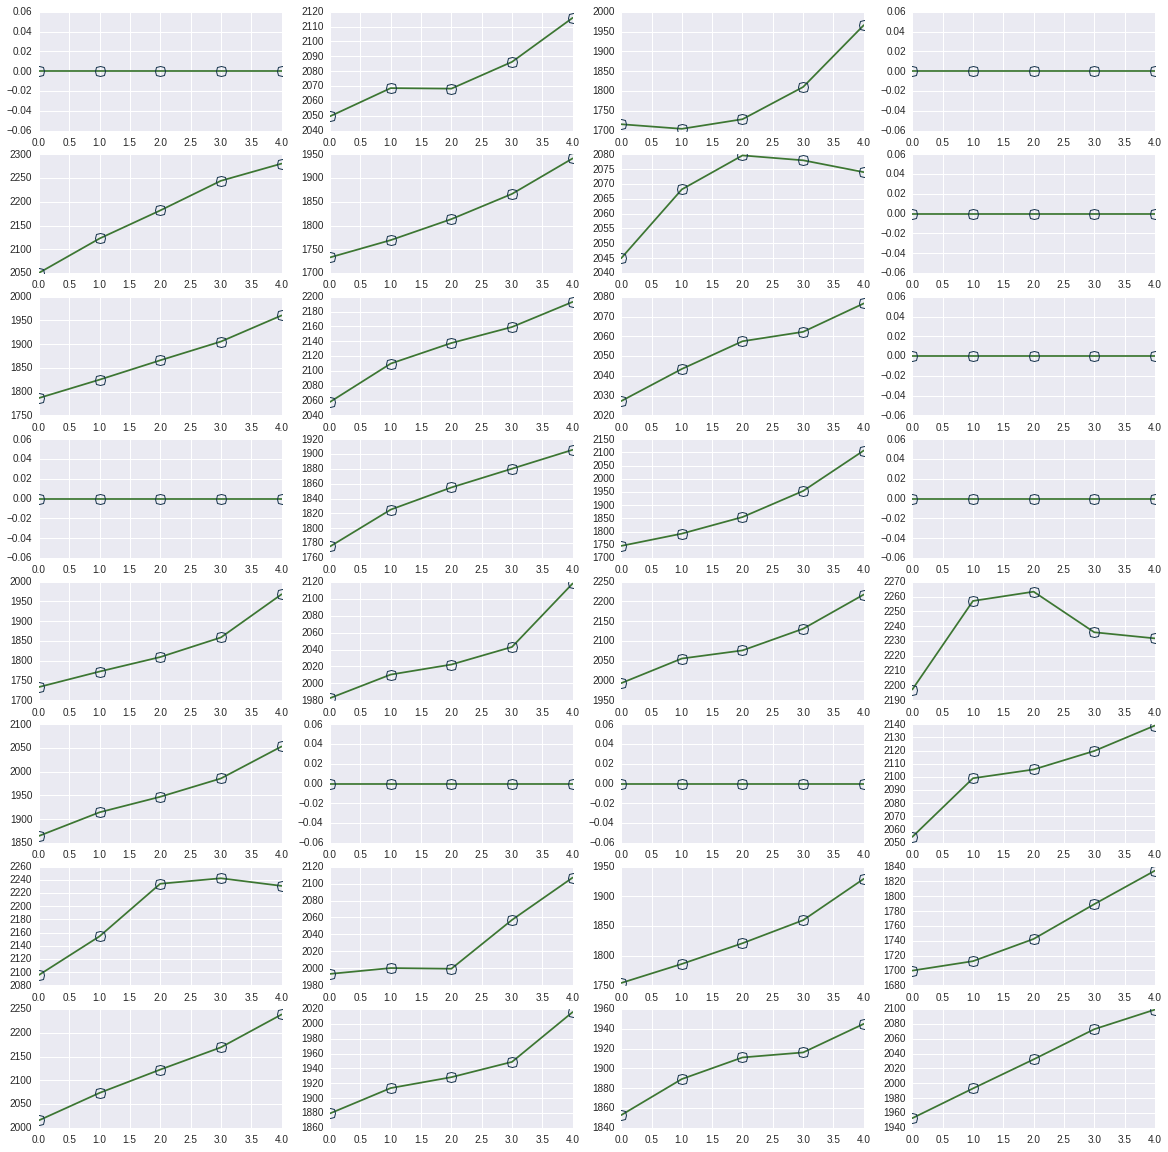

In [11]:
np.random.seed(seed=16)
nodes = np.random.randint(0,v.shape[0], 32)
x=np.arange(coeff.shape[1])

fig = plt.figure(figsize=(20,20))
for i in range(32):
    ax = fig.add_subplot(8,4,i+1)
    plt.plot(t1_profiles[nodes[i], 3:8], color=colors[3])
    plt.plot(np.polynomial.chebyshev.chebval(x, coeff[nodes[i]]), 
             color=colors[1], linestyle='None', fillstyle='none',
             marker='o', markersize=10,  markeredgewidth=1)
    #ax.set_ylim([1500,2500])

#### The same profiles between T1 1500 and 2500 (which will be used)

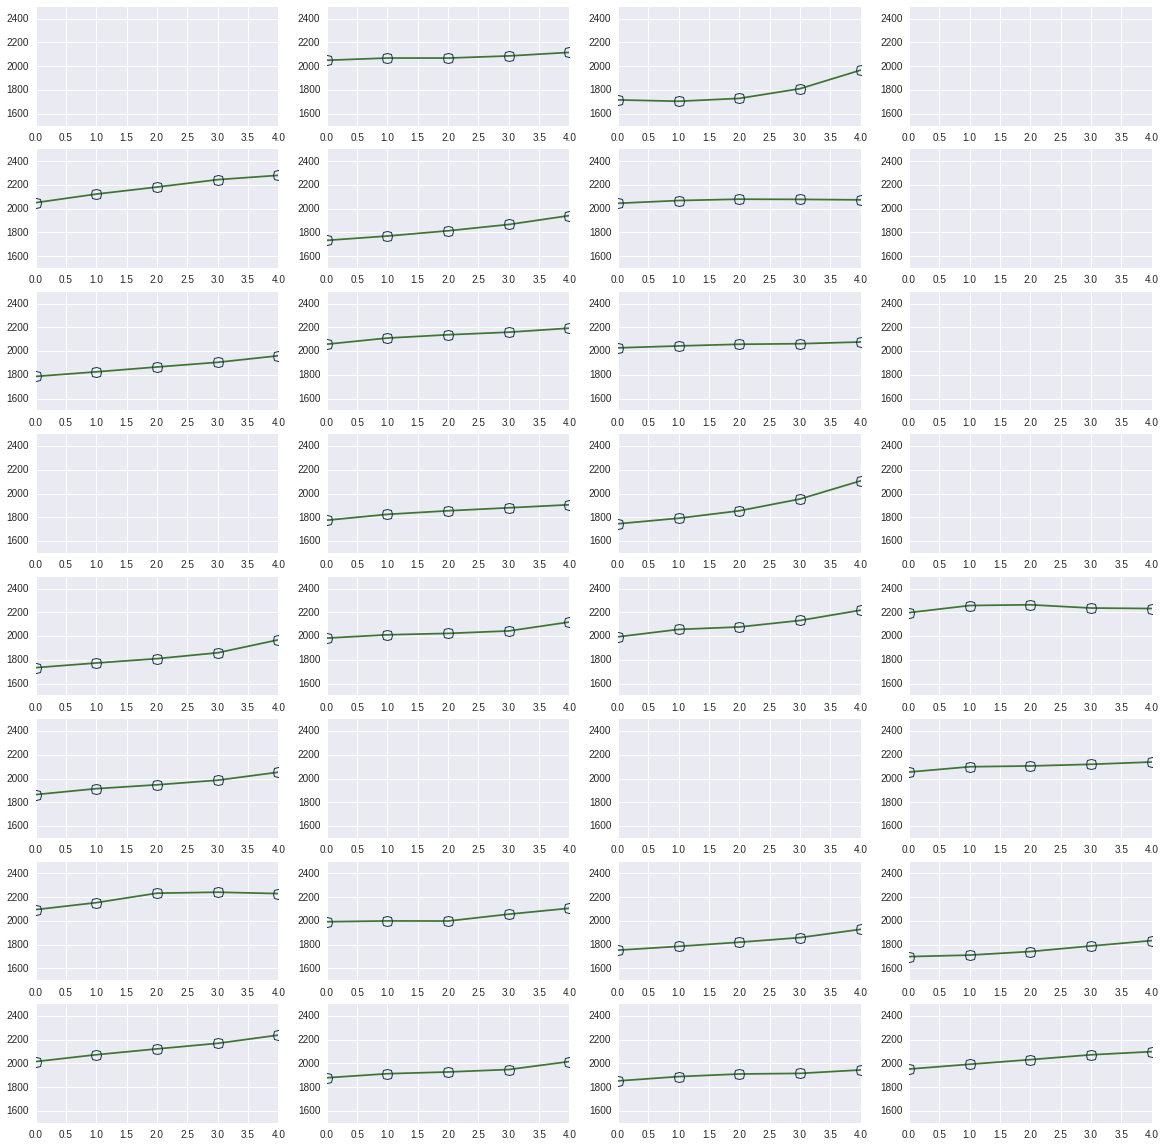

In [12]:
np.random.seed(seed=16)
nodes = np.random.randint(0,v.shape[0], 32)
x=np.arange(coeff.shape[1])

fig = plt.figure(figsize=(20,20))
for i in range(32):
    ax = fig.add_subplot(8,4,i+1)
    plt.plot(t1_profiles[nodes[i], 3:8], color=colors[3])
    plt.plot(np.polynomial.chebyshev.chebval(x, coeff[nodes[i]]), 
             color=colors[1], linestyle='None', fillstyle='none',
             marker='o', markersize=10,  markeredgewidth=1)
    ax.set_ylim([1500,2500])

#### Compare T1 average and zero coefficient

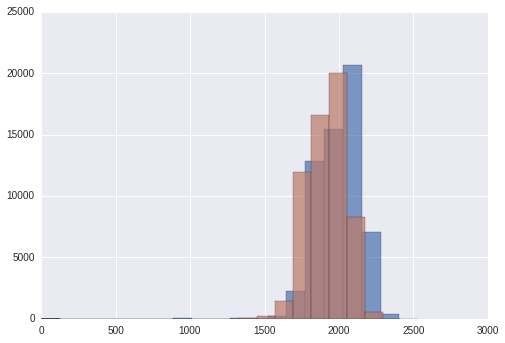

In [13]:
t1_avg_plot = np.delete(t1_avg, np.where(t1_avg==0))
coeff_0_plot = np.delete(coeff[:,0], np.where(coeff[:,0]==0))
plt.hist(t1_avg_plot, bins=20, alpha=0.7);
plt.hist(coeff_0_plot, bins=20, alpha=0.7, color = colors[5]);

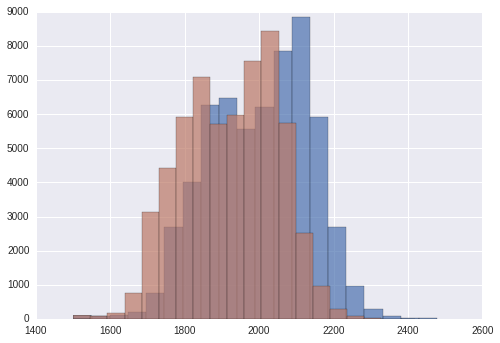

In [14]:
t1_avg_plot = np.delete(t1_avg, np.where(t1_avg<1500))
t1_avg_plot = np.delete(t1_avg_plot, np.where(t1_avg_plot>2500))
coeff_0_plot = np.delete(coeff[:,0], np.where(coeff[:,0]<1500))
coeff_0_plot = np.delete(coeff_0_plot, np.where(coeff_0_plot>2500))
plt.hist(t1_avg_plot, bins=20, alpha=0.7);
plt.hist(coeff_0_plot, bins=20, alpha=0.7, color = colors[5]);

### 2D histogramms

#### Prepare data so that only nodes with T1 between 1500 and 2500 and Embedding != 0 are kept in both arrays

In [16]:
scatter_t1avg = np.delete(t1_avg, mask)
scatter_coeff = np.delete(coeff, mask, axis=0)
scatter_embed = np.delete(embedding, mask, axis=0)

t1_idx=np.where(scatter_t1avg<=1500)
scatter_t1avg = np.delete(scatter_t1avg, t1_idx)
scatter_coeff = np.delete(scatter_coeff, t1_idx, axis=0)
scatter_embed = np.delete(scatter_embed, t1_idx, axis=0)

#t1_idx_2=np.where(t1_avg>=2500)
#scatter_t1avg = np.delete(scatter_t1avg, t1_idx_2)
#scatter_coeff = np.delete(scatter_coeff, t1_idx_2, axis=0)
#scatter_embed = np.delete(scatter_embed, t1_idx_2, axis=0)

#embed_idx=np.where(scatter_embed[:,0]==0)
#scatter_t1avg = np.delete(scatter_t1avg, embed_idx)
#scatter_coeff = np.delete(scatter_coeff, embed_idx, axis=0)
#scatter_embed = np.delete(scatter_embed, embed_idx, axis=0)

In [41]:
sns.set_style('darkgrid')

#### Intracortical avg T1

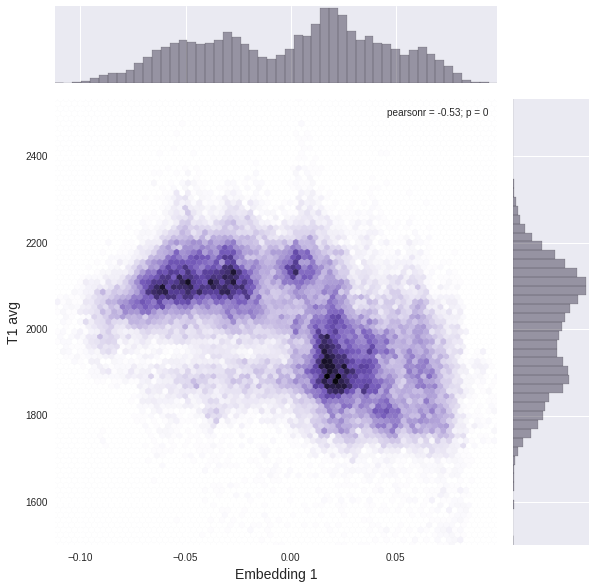

In [42]:
g = sns.jointplot(scatter_embed[:,0], scatter_t1avg, kind="hex", size=8, color=colors[0])
g.set_axis_labels('Embedding 1', 'T1 avg', fontsize=14)

#### Chebychev zero coeffiecient (~mean)

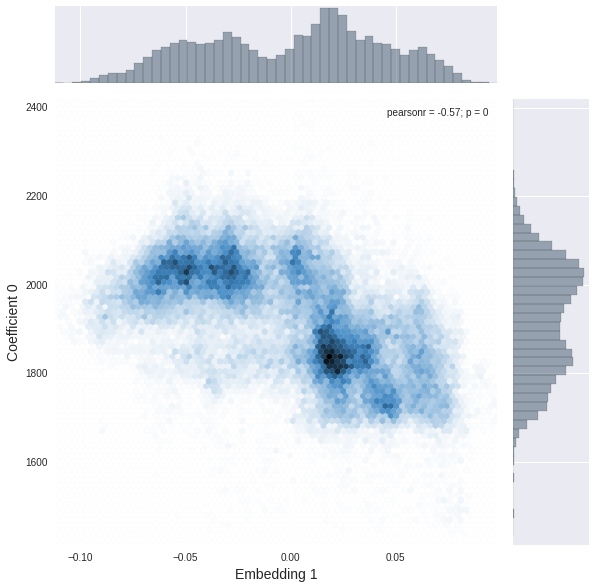

In [43]:
g = sns.jointplot(scatter_embed[:,0], scatter_coeff[:,0], kind="hex", size=8, color=colors[1])
g.set_axis_labels('Embedding 1', 'Coefficient 0', fontsize=14)

/usr/local/lib/python2.7/dist-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


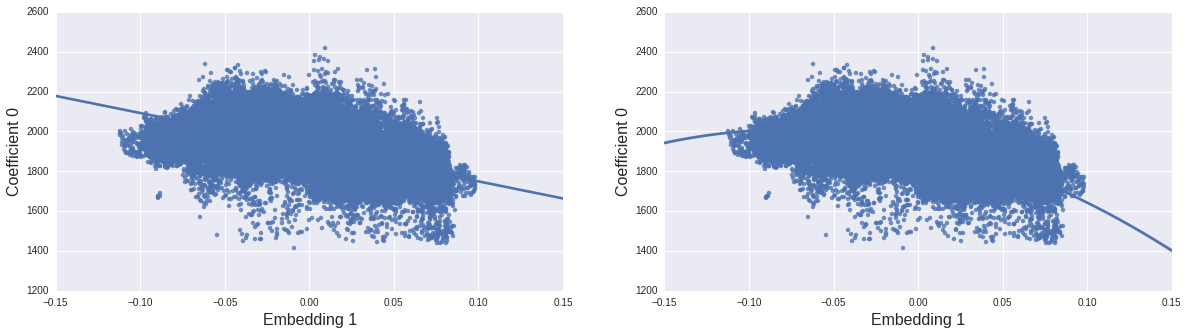

In [19]:
fig = plt.figure(figsize=(20,5))
fig.add_subplot(121)
ax = sns.regplot(x=scatter_embed[:,0], y=scatter_coeff[:,0], order=1);
ax.set_xlabel('Embedding 1', fontsize=16)
ax.set_ylabel('Coefficient 0', fontsize=16)
fig.add_subplot(122)
ax = sns.regplot(x=scatter_embed[:,0], y=scatter_coeff[:,0], order=2);
ax.set_xlabel('Embedding 1', fontsize=16)
ax.set_ylabel('Coefficient 0', fontsize=16)

#### Chebychev coefficient 1 (~slope)

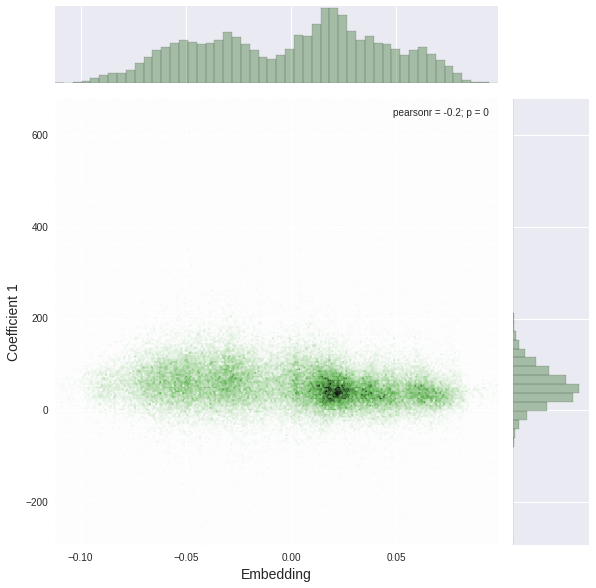

In [20]:
g = sns.jointplot(scatter_embed[:,0], scatter_coeff[:,1], kind="hex", color=colors[3], size=8)
g.set_axis_labels('Embedding', 'Coefficient 1', fontsize=14)

#### Chebychev coefficient 2 (~spread)

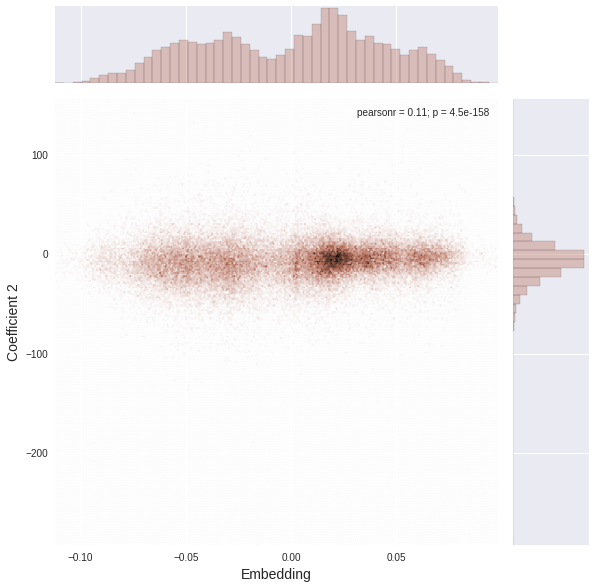

In [21]:
g = sns.jointplot(scatter_embed[:,0], scatter_coeff[:,2], kind="hex", color=colors[5], size=8)
g.set_axis_labels('Embedding', 'Coefficient 2', fontsize=14)

#### Chebychev coefficient 3

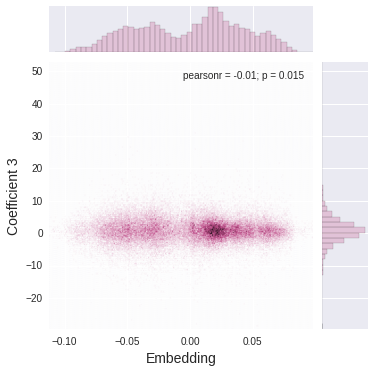

In [22]:
g = sns.jointplot(scatter_embed[:,0], scatter_coeff[:,3], kind="hex", color=colors[6], size=5)
g.set_axis_labels('Embedding', 'Coefficient 3', fontsize=14)

#### Chebychev coefficient 4

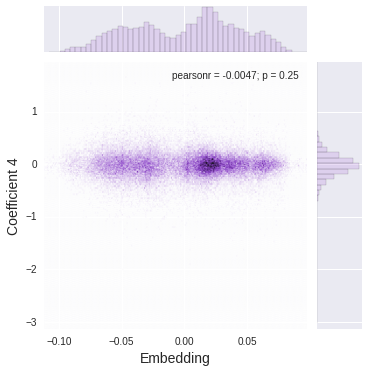

In [23]:
g = sns.jointplot(scatter_embed[:,0], scatter_coeff[:,4], kind="hex", color=colors[7], size=5)
g.set_axis_labels('Embedding', 'Coefficient 4', fontsize=14)

### Brains

In [47]:
sns.set_style('white')

#### 1st Embedding component

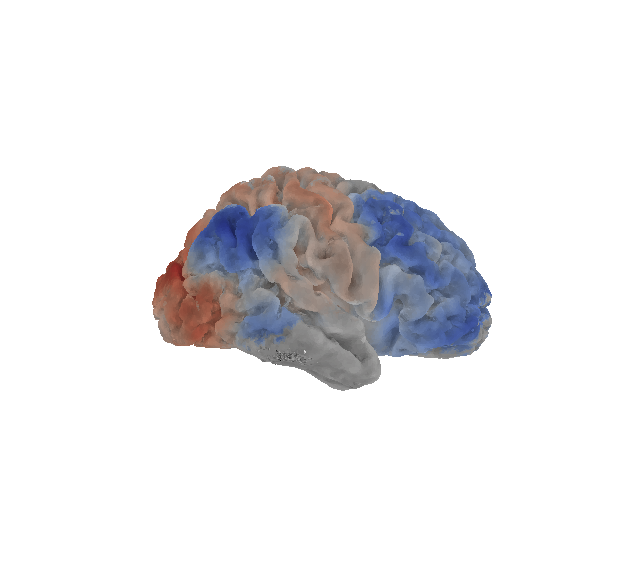

In [24]:
plot=plot_surf_stat_map(v, f, embedding[:,0], elev=180, azim=0, figsize=(11,10),
                        bg_map=sulc, bg_on_stat=True)

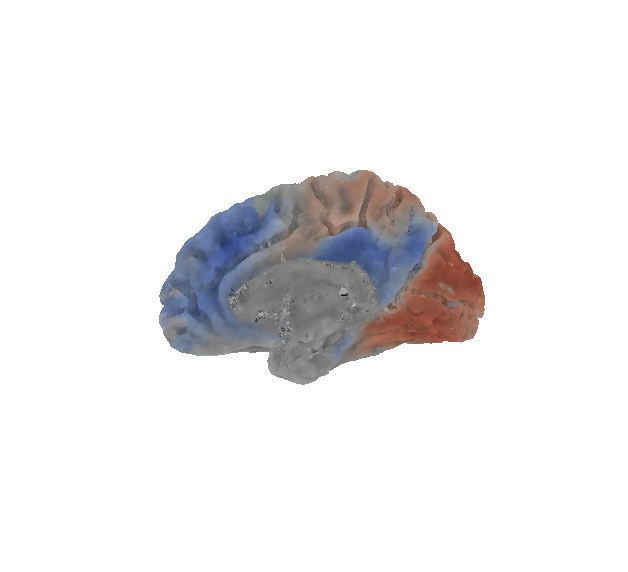

In [25]:
plot=plot_surf_stat_map(v, f, embedding[:,0], elev=180, azim=180, figsize=(11,10),
                        bg_map=sulc, bg_on_stat=True)

#### Intracortical avg T1, thresholded and brought down to avg zero

In [26]:
t1_avg_brain = t1_avg.copy()
t1_avg_brain[np.where(t1_avg<1500)]=1500
t1_avg_brain[np.where(t1_avg>2500)]=2500
t1_avg_brain -= np.mean(t1_avg_brain)
t1_avg_brain[mask] = 0

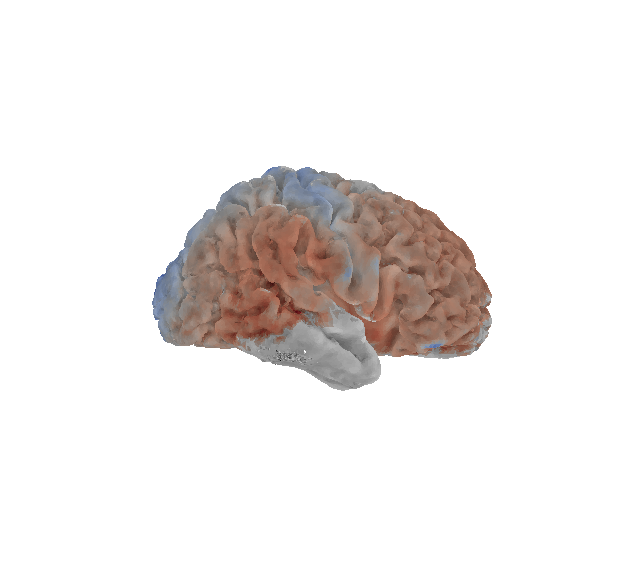

In [27]:
sns.set_style('white')
plot=plot_surf_stat_map(v, f, t1_avg_brain, elev=180, azim=0, figsize=(11,10),
                        bg_map=sulc, bg_on_stat=True, threshold=1e-50)

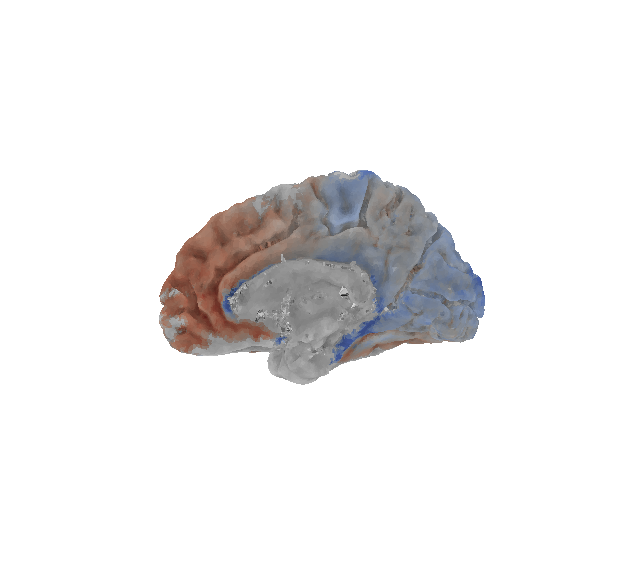

In [28]:
plot=plot_surf_stat_map(v, f, t1_avg_brain, elev=180, azim=180, figsize=(11,10),
                        bg_map=sulc, bg_on_stat=True, threshold=1e-50)

#### Chebychev coefficient zero, thresholded and brought down to avg zero

In [29]:
coeff0_brain = coeff[:,0].copy()
coeff0_brain[np.where(coeff0_brain<1500)]=1500
coeff0_brain[np.where(coeff0_brain>2500)]=2500
coeff0_brain -= np.mean(coeff0_brain)
coeff0_brain[mask] = 0

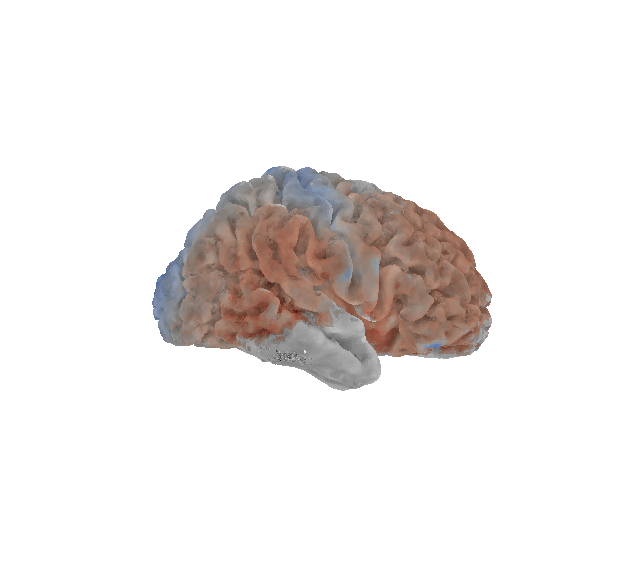

In [30]:
plot=plot_surf_stat_map(v, f, coeff0_brain, elev=180, azim=0, figsize=(11,10),
                        bg_map=sulc, bg_on_stat=True, threshold=1e-50)

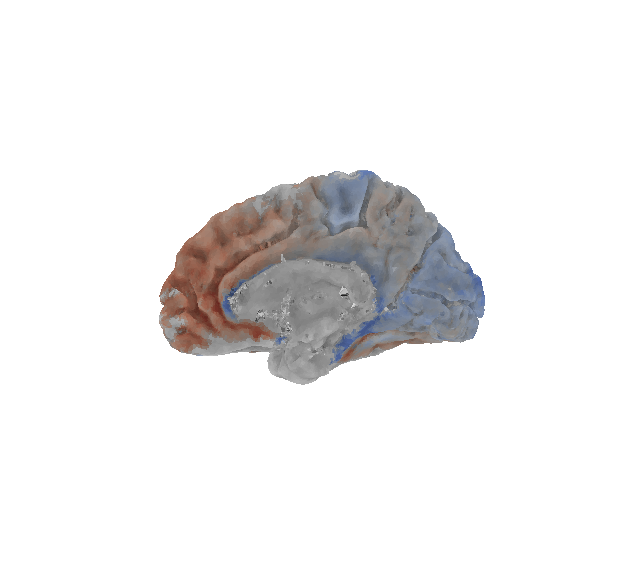

In [31]:
plot=plot_surf_stat_map(v, f, coeff0_brain, elev=180, azim=180, figsize=(11,10),
                        bg_map=sulc, bg_on_stat=True, threshold=1e-50)

#### Chebychev coefficient 1, thresholded and brought to mean zero

In [50]:
coeff1_brain = coeff[:,1].copy()
coeff1_brain[np.where(coeff1_brain<-100)]=-100
coeff1_brain[np.where(coeff1_brain>200)]=200
coeff1_brain -= np.mean(coeff1_brain)
coeff1_brain[mask] = 0

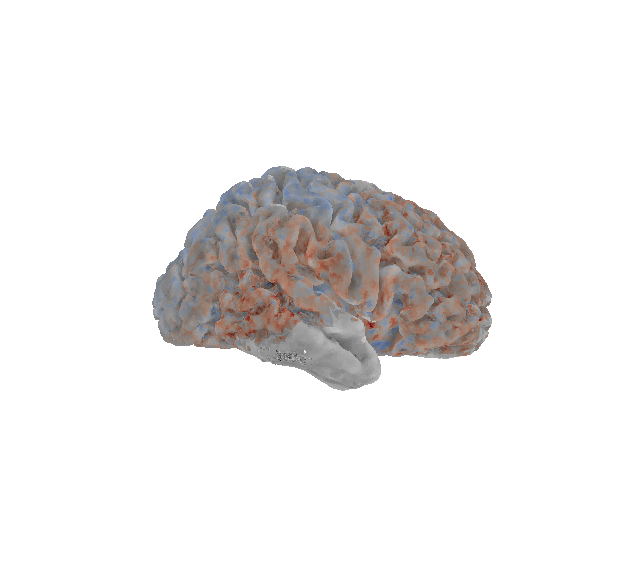

In [51]:
plot=plot_surf_stat_map(v, f, coeff1_brain, elev=180, azim=0, figsize=(11,10),
                        bg_map=sulc, bg_on_stat=True, threshold=1e-50)

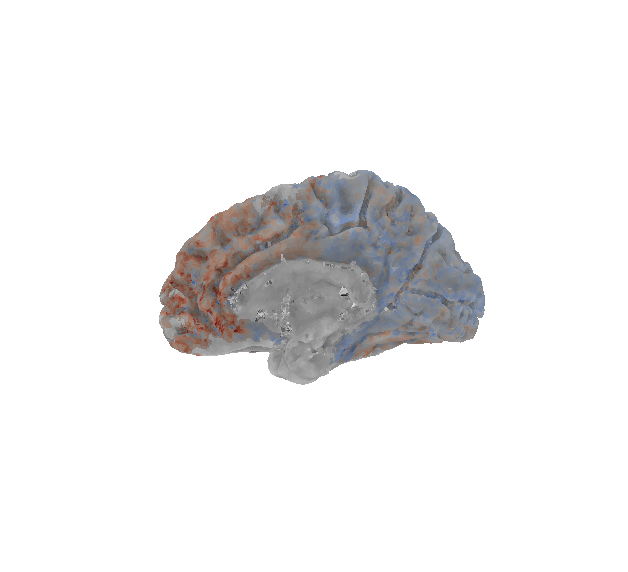

In [52]:
plot=plot_surf_stat_map(v, f, coeff1_brain, elev=180, azim=180, figsize=(11,10),
                        bg_map=sulc, bg_on_stat=True, threshold=1e-50)